In [118]:
import sql as gd
import pandas as pd
import seaborn as sns
import sqlalchemy
import psycopg2
import datetime
import time

## First we get the table from the sql database

In [119]:
flights = gd.get_data('SELECT * FROM cap_air.flights_ger')

/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/pandas/io/sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## We need only flights from 2017 - 2021

flights['arr_date'] = pd.to_datetime(flights['arr_date'])
flights['dep_date'] = pd.to_datetime(flights['dep_date'])

flights = flights[(flights['arr_date'] < '2022-01-01') & (flights['dep_date'] < '2022-01-01')]

## We got 5.724.931 flights in total from the OpenSky API

In [201]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5724931 entries, 0 to 5743851
Data columns (total 11 columns):
 #   Column     Dtype         
---  ------     -----         
 0   icao       object        
 1   firstseen  float64       
 2   departure  object        
 3   lastseen   int64         
 4   arrival    object        
 5   callsign   object        
 6   airline    object        
 7   arr_time   object        
 8   dep_time   object        
 9   arr_date   datetime64[ns]
 10  dep_date   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 524.1+ MB


## We filter so we only have the nightflights

In [226]:
from datetime import date, time, datetime

# boundaries for the nighttime
start = time(hour=22, minute=00, second=00)
end = time(hour=6, minute=00, second=00)

airports = ['EDDB',
            'EDLW',
            'EDDW',
            'EDDT',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]
# we need this conversion later for the grouping by month and year
flights['arr_date'] = pd.to_datetime(flights['arr_date'])
flights['dep_date'] = pd.to_datetime(flights['dep_date'])

# filtered nightflights by arrival and the needed timeframe
nf_arr = pd.concat([flights[(flights['arr_time'] > start) & (flights['arrival'].isin(airports)) & (flights['arr_date'] < '2022-01-01')],
                    flights[(flights['arr_time'] < end) & (flights['arrival'].isin(airports)) & (flights['arr_date'] < '2022-01-01')]])
# filtered nightflights by departure and the needed timeframe
nf_dep = pd.concat([flights[(flights['dep_time'] > start) & (flights['departure'].isin(airports)) & (flights['dep_date'] < '2022-01-01')],
                    flights[(flights['dep_time'] < end) & (flights['departure'].isin(airports)) & (flights['dep_date'] < '2022-01-01')]])
# merged arrival and departure again to get all nightflights
nf = pd.concat([nf_arr, nf_dep])
# there are still duplicates so we drop them again
nf.drop_duplicates(inplace=True)
# looked at special flights in sql database where arrival and departure is the same airport
# they are not relevant because most of them are police helicopters and flights we can't match by icao or callsign
nf = nf.query('arrival != departure')



## Quick look at the result

In [227]:
nf

,icao,firstseen,departure,lastseen,arrival,callsign,airline,arr_time,dep_time,arr_date,dep_date
151,3c56f3,1.594149e+09,None,1594157797,EDDH,EWG3HN,EWG,23:36:37,21:15:30,2020-07-07,2020-07-07
152,4cab11,1.594148e+09,None,1594155321,EDDH,HYR95V,HYR,22:55:21,21:00:30,2020-07-07,2020-07-07
153,3c56e6,1.594146e+09,LEPA,1594154369,EDDH,EWG5KG,EWG,22:39:29,20:12:45,2020-07-07,2020-07-07
154,3c65d5,1.594150e+09,EDDM,1594153637,EDDH,DLH5CW,DLH,22:27:17,21:20:30,2020-07-07,2020-07-07
224,3c56e7,1.594061e+09,LEPA,1594069366,EDDH,EWG9MR,EWG,23:02:46,20:36:31,2020-07-06,2020-07-06
...,...,...,...,...,...,...,...,...,...,...,...
5741322,3cc24a,1.588736e+09,EDDM,1588740218,EDDH,DCAWO,DCA,06:43:38,05:41:26,2020-05-06,2020-05-06
5741669,3cc24a,1.590119e+09,EDDM,1590122729,EDDH,DCAWO,DCA,06:45:29,05:41:23,2020-05-22,2020-05-22
5741775,3ddc70,1.590105e+09,EDDH,1590107921,None,CHX86,CHX,02:38:41,01:57:26,2020-05-22,2020-05-22
5742182,3cc187,1.591414e+09,EDDM,1591417136,EDDH,DCAPB,DCA,06:18:56,05:25:39,2020-06-06,2020-06-06


## Sanity Check
## Proof the table only contains nightflights

In [228]:
nf[(nf['arr_time'] < start) & (nf['arr_time'] > end) & (nf['dep_time'] < start) & (nf['dep_time'] > end)]

,icao,firstseen,departure,lastseen,arrival,callsign,airline,arr_time,dep_time,arr_date,dep_date


In [229]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674503 entries, 151 to 5742261
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   icao       674503 non-null  object        
 1   firstseen  674503 non-null  float64       
 2   departure  555048 non-null  object        
 3   lastseen   674503 non-null  int64         
 4   arrival    601011 non-null  object        
 5   callsign   671766 non-null  object        
 6   airline    671766 non-null  object        
 7   arr_time   674503 non-null  object        
 8   dep_time   674503 non-null  object        
 9   arr_date   674503 non-null  datetime64[ns]
 10  dep_date   674503 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 61.8+ MB


## Percentage of nightflights - 11,7 %

In [230]:
perc = len(nf)/len(flights)
perc

0.11781853790028211

## Start exploring a bit

In [231]:
nf_hh_arr = nf[nf['arrival'] == 'EDDH'].groupby('arr_date').count()['arrival'].reset_index()
nf_hh_arr

,arr_date,arrival
0,2017-01-01,15
1,2017-01-02,13
2,2017-01-03,13
3,2017-01-04,18
4,2017-01-05,10
...,...,...
1800,2021-12-27,5
1801,2021-12-28,5
1802,2021-12-29,7
1803,2021-12-30,10


In [232]:
nf_hh_dep = nf[nf['departure'] == 'EDDH'].groupby('dep_date').count()['departure']
nf_hh_dep

dep_date
2017-01-01     1
2017-01-02    10
2017-01-03     3
2017-01-05     5
2017-01-06     1
              ..
2021-12-23     4
2021-12-26     6
2021-12-27     4
2021-12-29     3
2021-12-30     1
Name: departure, Length: 1483, dtype: int64

In [233]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])

nf.groupby(pd.Grouper(key='arr_date', freq='M')).count()

,icao,firstseen,departure,lastseen,arrival,callsign,airline,arr_time,dep_time,dep_date
arr_date,,,,,,,,,,
2017-01-31,7490,7490,5532,7490,6281,7457,7457,7490,7490,7490
2017-02-28,7188,7188,5568,7188,6184,7152,7152,7188,7188,7188
2017-03-31,9058,9058,7015,9058,7737,9000,9000,9058,9058,9058
2017-04-30,11724,11724,8760,11724,9887,11669,11669,11724,11724,11724
2017-05-31,13814,13814,10407,13814,11620,13754,13754,13814,13814,13814
2017-06-30,14141,14141,10848,14141,11933,14077,14077,14141,14141,14141
2017-07-31,15608,15608,12007,15608,13018,15547,15547,15608,15608,15608
2017-08-31,14551,14551,10969,14551,12110,14483,14483,14551,14551,14551
2017-09-30,14950,14950,11492,14950,12590,14884,14884,14950,14950,14950


In [234]:
nf[nf['arrival'] == 'EDDH'].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()

,arr_date,arrival
0,2017-01-31,287
1,2017-02-28,266
2,2017-03-31,359
3,2017-04-30,466
4,2017-05-31,427
5,2017-06-30,658
6,2017-07-31,689
7,2017-08-31,650
8,2017-09-30,666
9,2017-10-31,625


## Borrow code from the internet

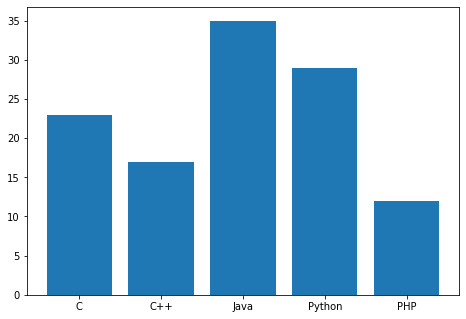

In [235]:
# simple example from the internet

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(langs,students)
plt.show()

<BarContainer object of 5 artists>

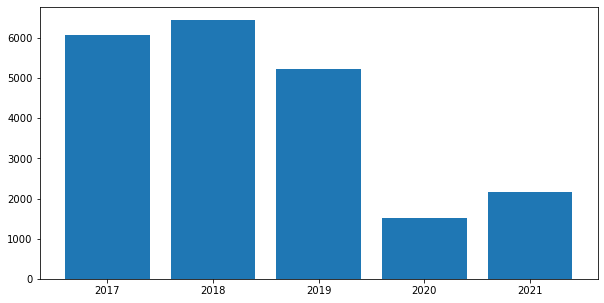

In [236]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

nf['arr_date'] = pd.to_datetime(nf['arr_date'])

nf_arr = nf[nf['arrival'] == 'EDDH'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(x=['2017','2018','2019','2020','2021'], height=nf_arr['arrival'])

In [237]:
nf_arr = nf[nf['arrival'] == 'EDDH'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count().reset_index()
nf_arr

,arr_date,arrival
0,2017-12-31,6064
1,2018-12-31,6450
2,2019-12-31,5228
3,2020-12-31,1515
4,2021-12-31,2152


In [238]:
nf_dep = nf[nf['departure'] == 'EDDH'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count().reset_index()
nf_dep

,dep_date,departure
0,2017-12-31,1583
1,2018-12-31,2011
2,2019-12-31,2029
3,2020-12-31,417
4,2021-12-31,437


In [239]:
nf_hh = (nf[nf['arrival'] == 'EDDH'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count()) + (nf[nf['departure'] == 'EDDH'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count())
nf_hh

arr_date
2017-12-31    7647
2018-12-31    8461
2019-12-31    7257
2020-12-31    1932
2021-12-31    2589
Freq: A-DEC, dtype: int64

<BarContainer object of 5 artists>

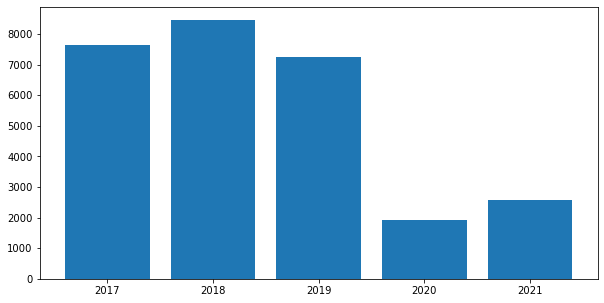

In [240]:
plt.figure(figsize=(10, 5))
plt.bar(x=['2017','2018','2019','2020','2021'], height=nf_hh)

## The difference between arrival and departure could be interesting
## Borrowed code for our case from the internet

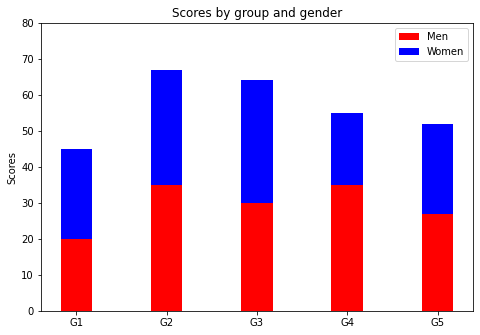

In [241]:
# example from the internet

import numpy as np
import matplotlib.pyplot as plt
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Men', 'Women'])
plt.show()


## As usual we looked at Hamburg first

## The ranges of the y-axis differ!!!

## There are cities with a lot of nightflights and cities with a lot less nightflights

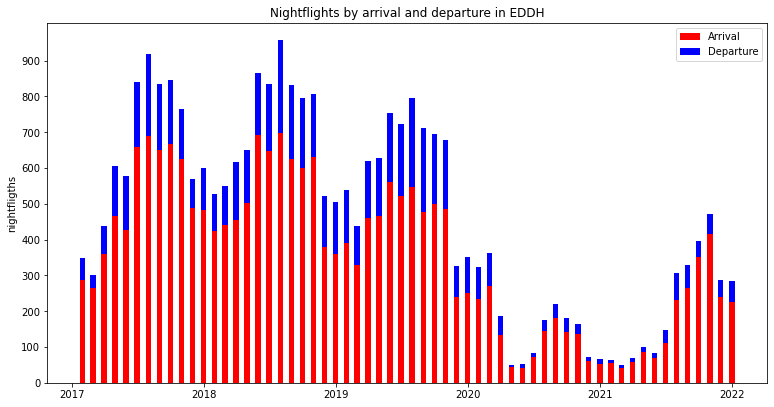

In [242]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airport = 'EDDH'

arr_hh = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
dep_hh = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr_hh, width, color='r')
ax.bar(ind, dep_hh, width,bottom=arr_hh, color='b')
ax.set_ylabel('nightfligths')
ax.set_title(f'Nightflights by arrival and departure in {airport}')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 1000, 100))
ax.legend(labels=['Arrival', 'Departure'])

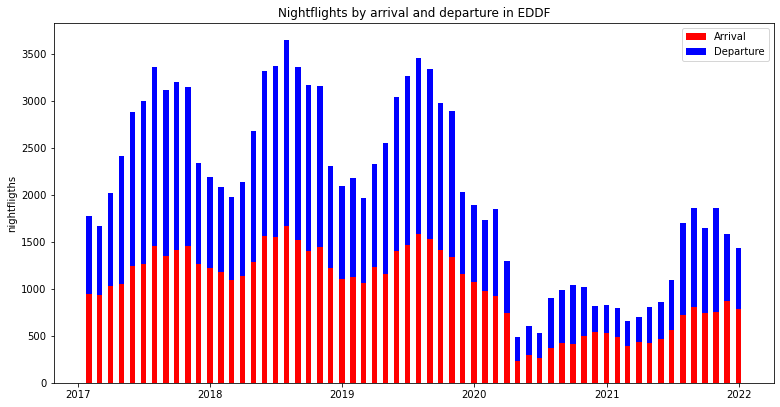

In [243]:
import numpy as np
import matplotlib.pyplot as plt

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airport = 'EDDF'

arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr, width, color='r')
ax.bar(ind, dep, width,bottom=arr, color='b')
ax.set_ylabel('nightfligths')
ax.set_title(f'Nightflights by arrival and departure in {airport}')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 4000, 500))
ax.legend(labels=['Arrival', 'Departure'])

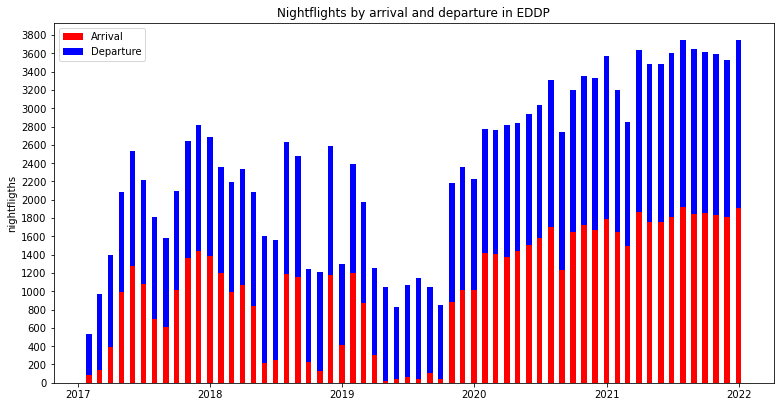

In [244]:
import numpy as np
import matplotlib.pyplot as plt

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airport = 'EDDP'

arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr, width, color='r')
ax.bar(ind, dep, width,bottom=arr, color='b')
ax.set_ylabel('nightfligths')
ax.set_title(f'Nightflights by arrival and departure in {airport}')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 4000, 200))
ax.legend(labels=['Arrival', 'Departure'])

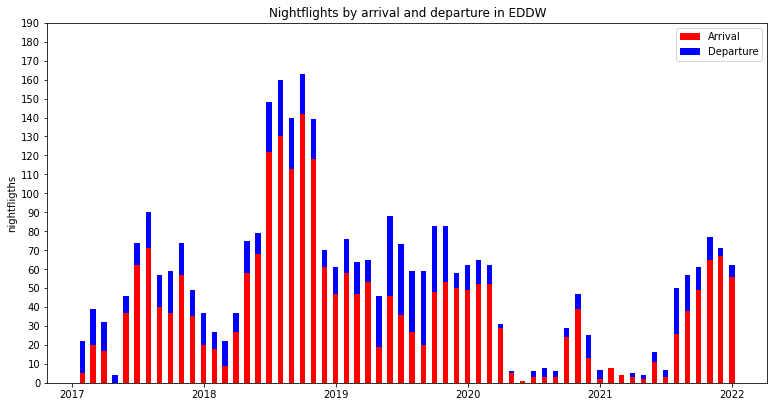

In [245]:
import numpy as np
import matplotlib.pyplot as plt

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airport = 'EDDW'

arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr, width, color='r')
ax.bar(ind, dep, width,bottom=arr, color='b')
ax.set_ylabel('nightfligths')
ax.set_title(f'Nightflights by arrival and departure in {airport}')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 200, 10))
ax.legend(labels=['Arrival', 'Departure'])

## Plot of nightflights of all cities combined

## We can see in the summer are more nightflights

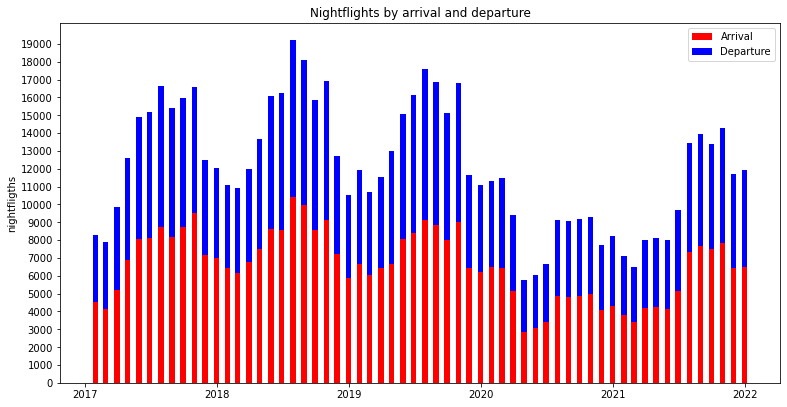

In [246]:
import numpy as np
import matplotlib.pyplot as plt

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

arr_hh = nf[nf['arrival'].isin(airports)].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
dep_hh = nf[nf['departure'].isin(airports)].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
ind = nf[nf['arrival'].isin(airports)].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr_hh, width, color='r')
ax.bar(ind, dep_hh, width,bottom=arr_hh, color='b')
ax.set_ylabel('nightfligths')
ax.set_title('Nightflights by arrival and departure')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 20000, 1000))
ax.legend(labels=['Arrival', 'Departure'])

## Want to Subplot all airports

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (60,) and arg 1 with shape (59,).

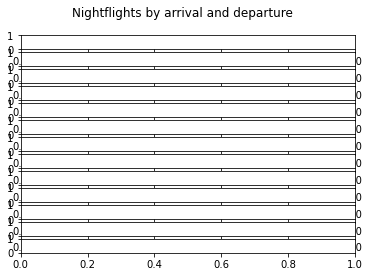

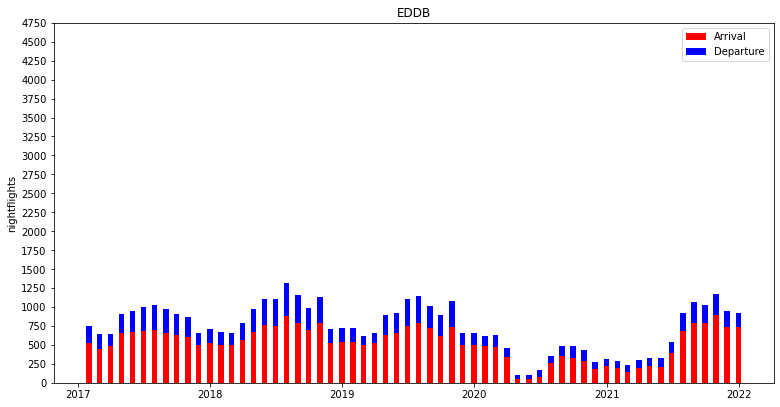

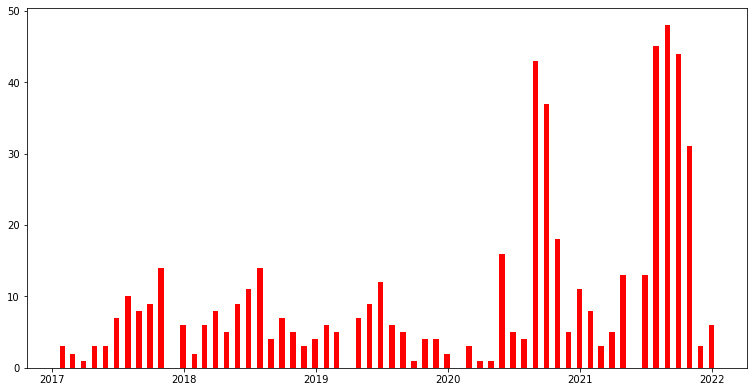

In [247]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

fig, axs = plt.subplots(13)
fig.suptitle('Nightflights by arrival and departure')
for i, airport in enumerate(airports):
    arr_hh = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
    dep_hh = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
    ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
    width = 15
    fig = plt.figure(figsize=(10, 5))
    axs[i] = fig.add_axes([0,0,1,1])
    axs[i].bar(ind, arr_hh, width, color='r')
    axs[i].bar(ind, dep_hh, width, bottom=arr_hh, color='b')
    axs[i].set_title(airport)
    axs[i].set_ylabel('nightflights')
    axs[i].set_yticks(np.arange(0, 5000, 250))
    axs[i].legend(labels=['Arrival', 'Departure'])
    


## Why does the error occur?

## Are there months missing at one airport?

## Month intervals from the airports don't seem to match

## Something is wrong with Dortmund. We can see no departure values


## Grouping by year works

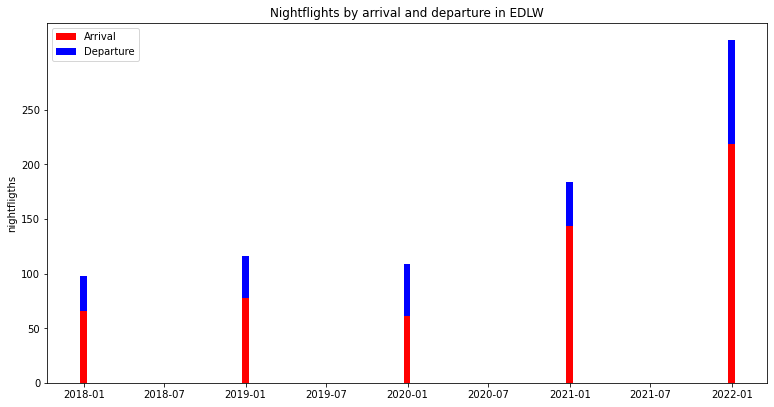

In [249]:
import numpy as np
import matplotlib.pyplot as plt

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airport = 'EDLW'

arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count()
dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
# tested indexing with the departure
ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
width = 15
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, arr, width, color='r')
ax.bar(ind, dep, width,bottom=arr, color='b')
ax.set_ylabel('nightfligths')
ax.set_title(f'Nightflights by arrival and departure in {airport}')
#ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 300, 50))
ax.legend(labels=['Arrival', 'Departure'])

## January 2017 of Dortmund in departure is missing!!!

In [252]:
nf[nf['departure'] == 'EDLW'].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count().reset_index()

,dep_date,departure
0,2017-02-28,1
1,2017-03-31,1
2,2017-04-30,4
3,2017-05-31,0
4,2017-06-30,3
5,2017-07-31,3
6,2017-08-31,3
7,2017-09-30,4
8,2017-10-31,10
9,2017-11-30,0


## We leave out Dortmund and test again

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (59,) and arg 1 with shape (60,).

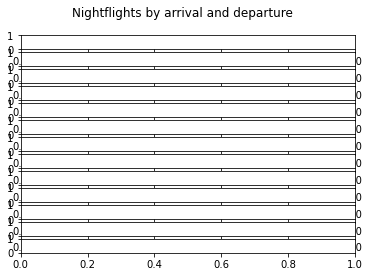

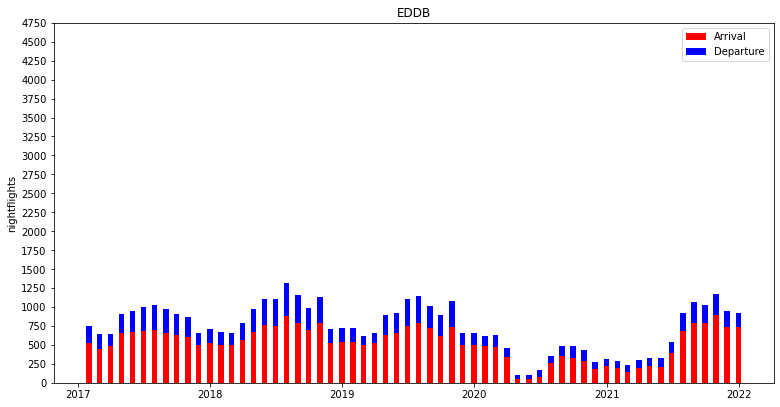

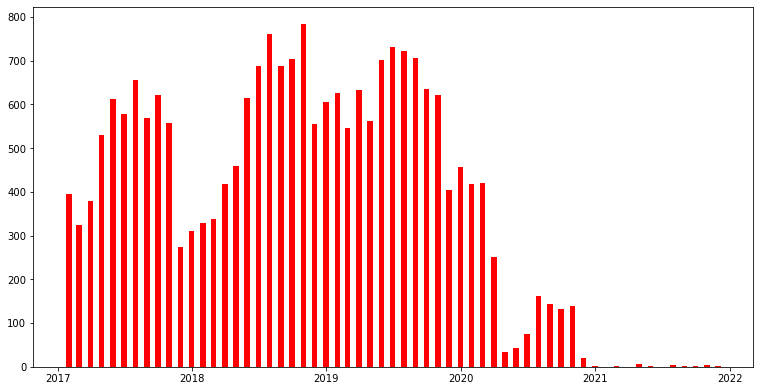

In [253]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airports = ['EDDB',
            'EDDT',
            'EDDW',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

fig, axs = plt.subplots(13)
fig.suptitle('Nightflights by arrival and departure')
for i, airport in enumerate(airports):
    arr_hh = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
    dep_hh = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
    ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
    width = 15
    fig = plt.figure(figsize=(10, 5))
    axs[i] = fig.add_axes([0,0,1,1])
    axs[i].bar(ind, arr_hh, width, color='r')
    axs[i].bar(ind, dep_hh, width, bottom=arr_hh, color='b')
    axs[i].set_title(airport)
    axs[i].set_ylabel('nightflights')
    axs[i].set_yticks(np.arange(0, 5000, 250))
    axs[i].legend(labels=['Arrival', 'Departure'])
    

    

## Now we have an error at Berlin Tegel
## Looking for missing months in Berlin

In [255]:
nf[nf['arrival'] == 'EDDT'].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count().reset_index()

,dep_date,departure
0,2017-01-31,362
1,2017-02-28,306
2,2017-03-31,346
3,2017-04-30,408
4,2017-05-31,496
5,2017-06-30,458
6,2017-07-31,523
7,2017-08-31,457
8,2017-09-30,496
9,2017-10-31,443


## Arrivals for December 2021 in Berlin Tegel are missing or there are no nightflights!!
## We also leave out Berlin and test again

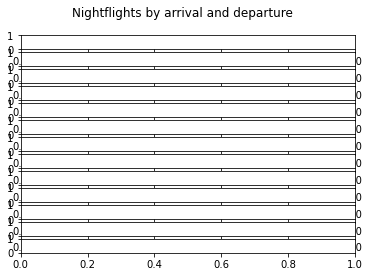

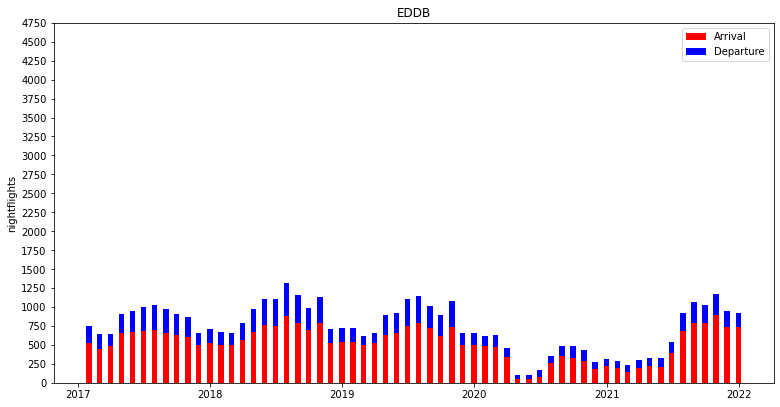

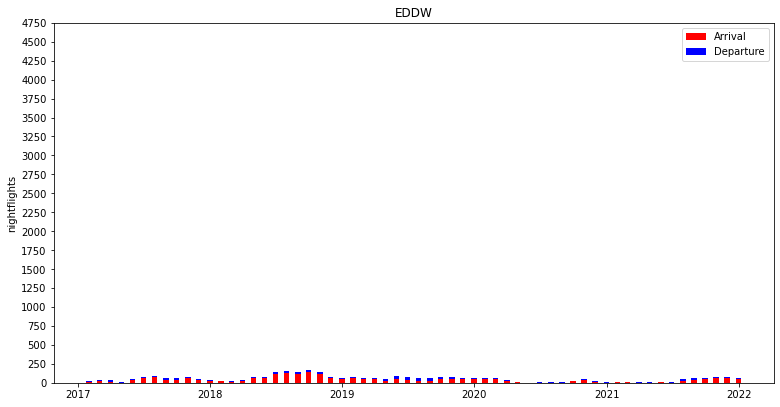

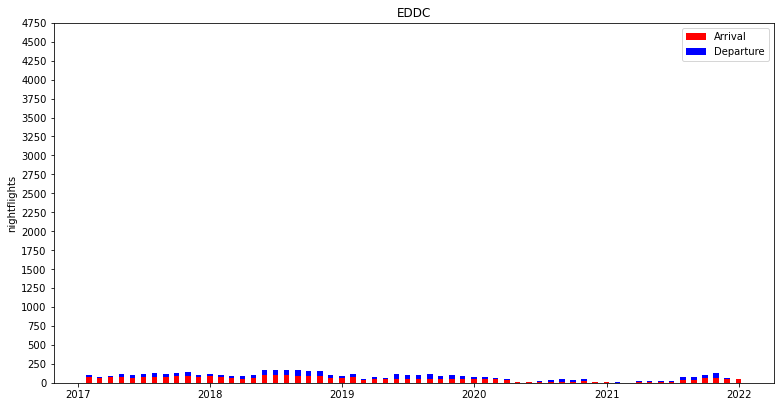

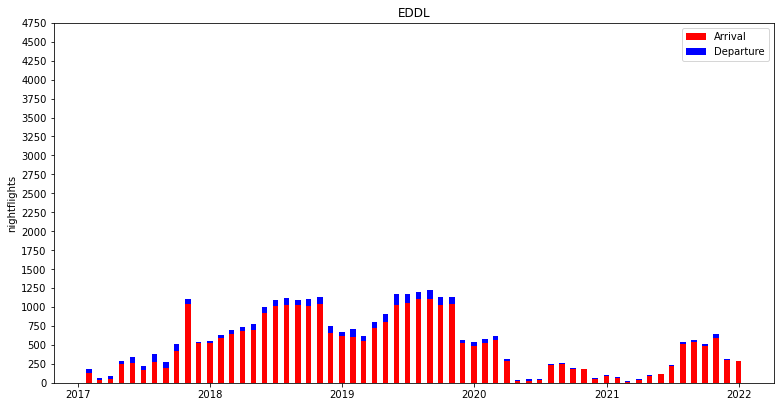

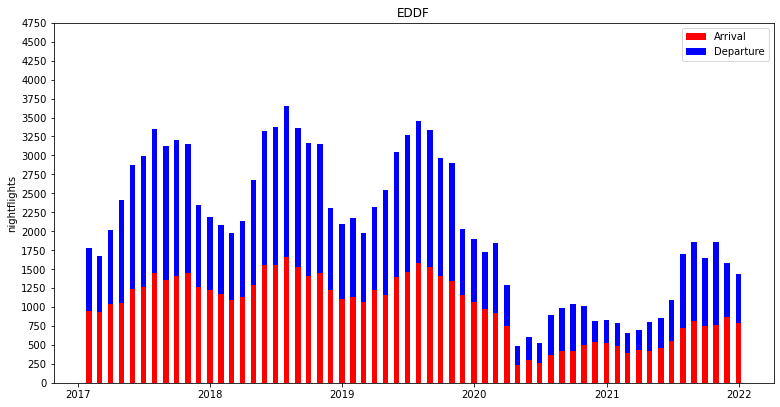

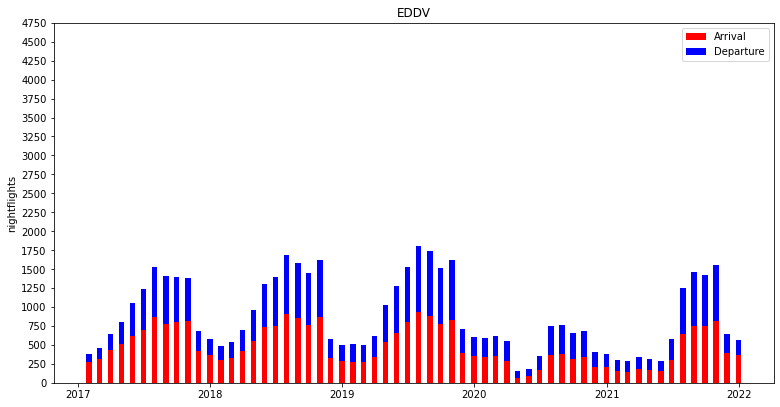

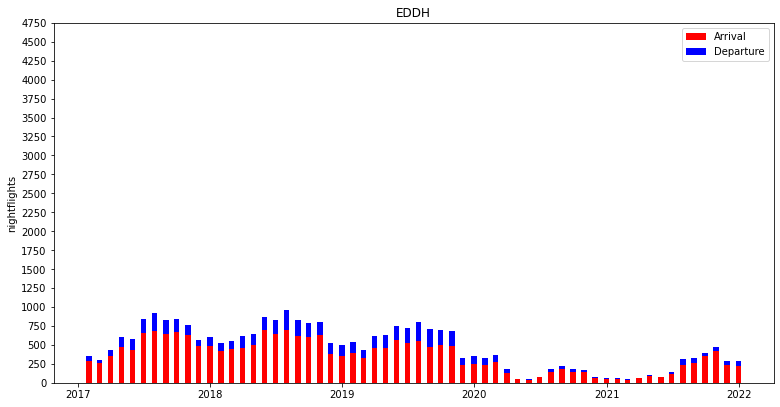

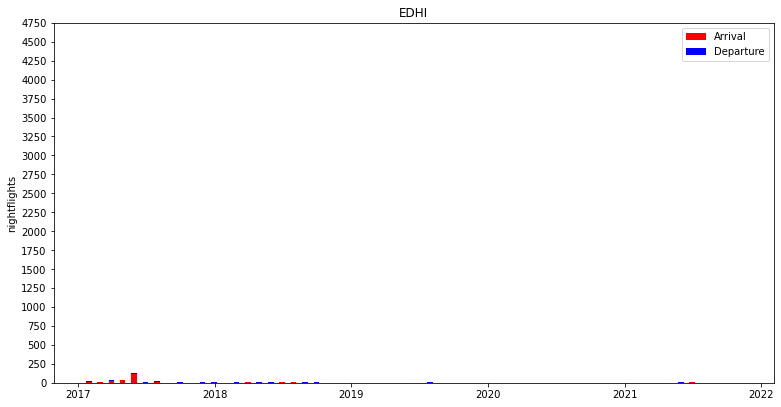

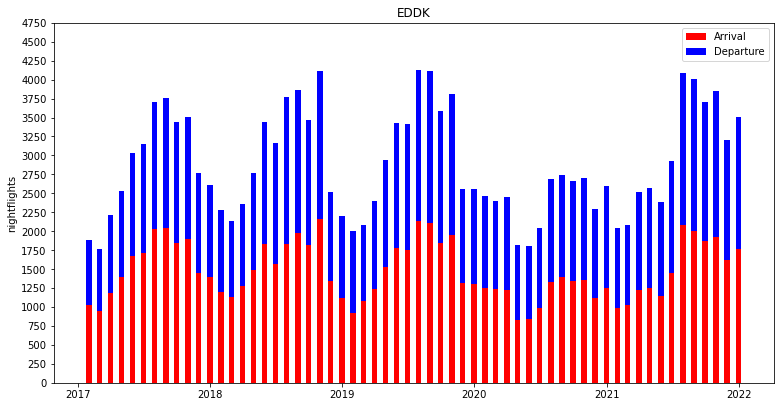

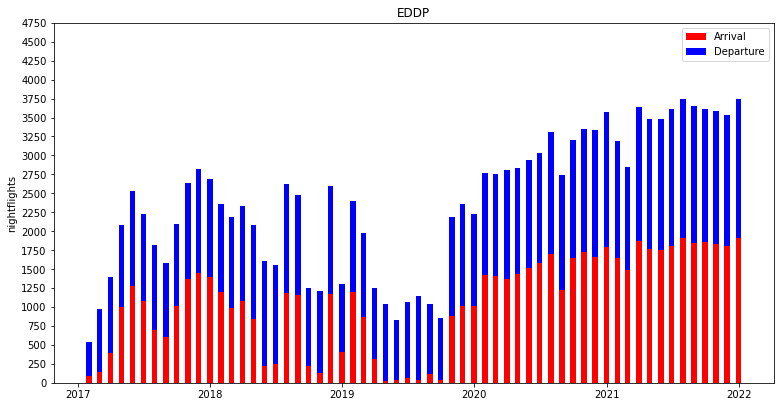

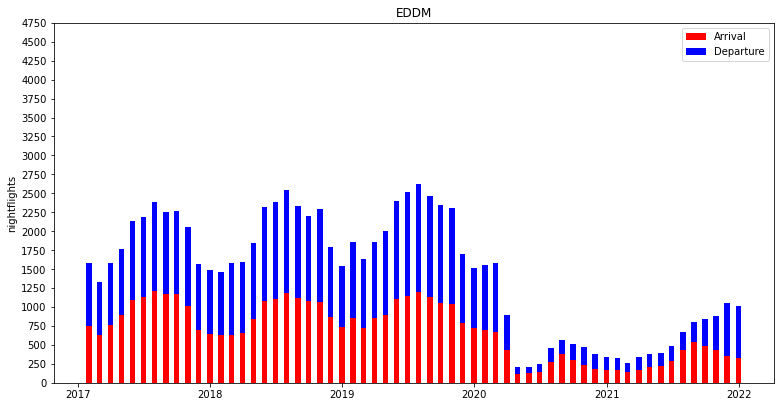

In [257]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airports = ['EDDB',
            'EDDW',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

fig, axs = plt.subplots(13)
fig.suptitle('Nightflights by arrival and departure')
for i, airport in enumerate(airports):
    arr_hh = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
    dep_hh = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
    ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
    width = 15
    fig = plt.figure(figsize=(10, 5))
    axs[i] = fig.add_axes([0,0,1,1])
    axs[i].bar(ind, arr_hh, width, color='r')
    axs[i].bar(ind, dep_hh, width, bottom=arr_hh, color='b')
    axs[i].set_title(airport)
    axs[i].set_ylabel('nightflights')
    axs[i].set_yticks(np.arange(0, 5000, 250))
    axs[i].legend(labels=['Arrival', 'Departure'])
    

    

## It shows all plots but it seems the code is bullshit because subplotting doesn't work
## Leave the idea of subplotting
## Especially Hannover is interesting. It confirms the report of NDR where they say that there are many flights in the summer vacations and in Hannover are no restrictions!! Maybe good for the presentation
## Actually you can see this pattern in most of the airports

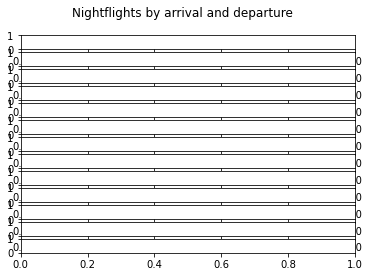

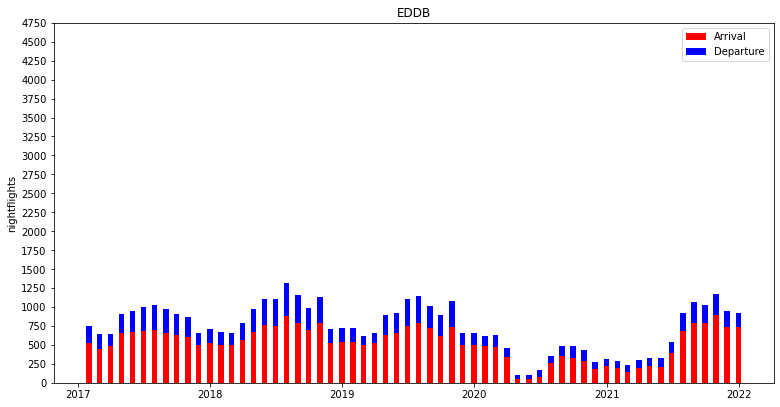

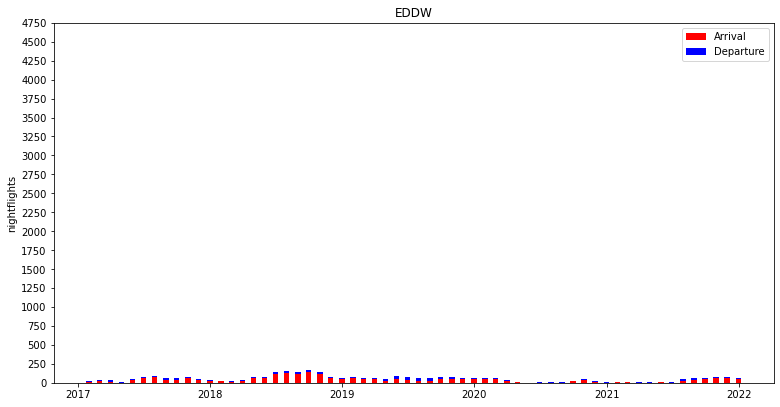

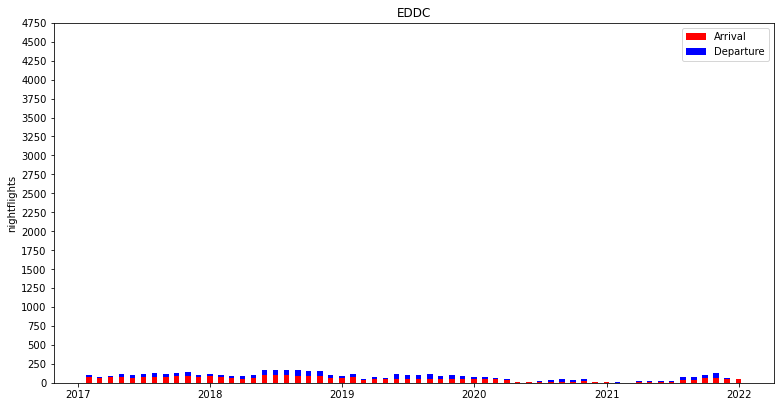

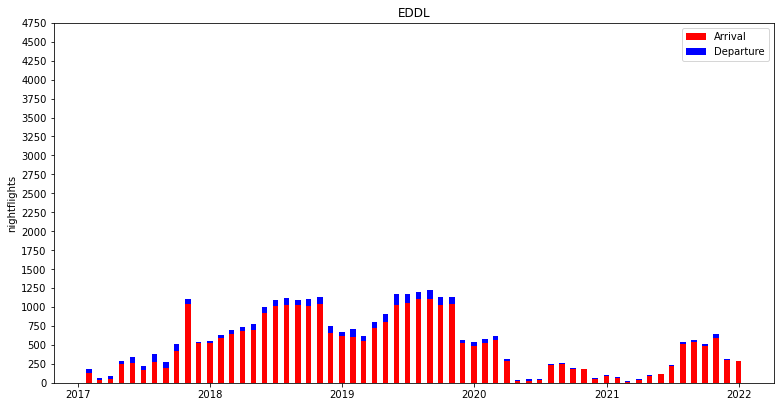

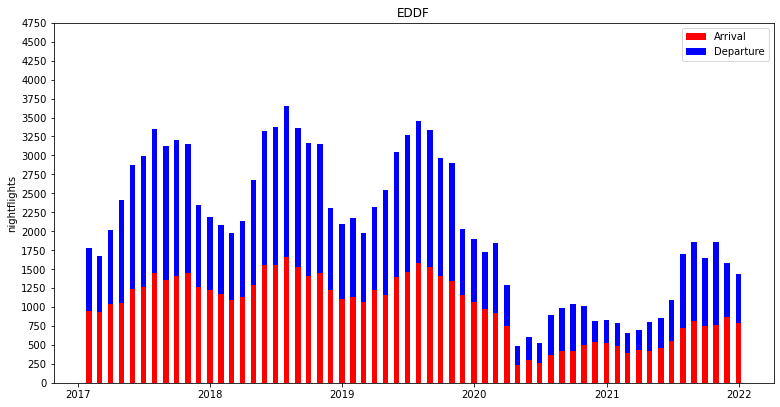

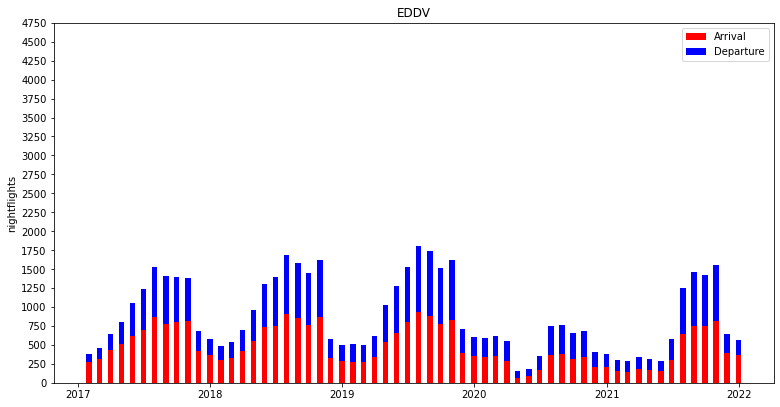

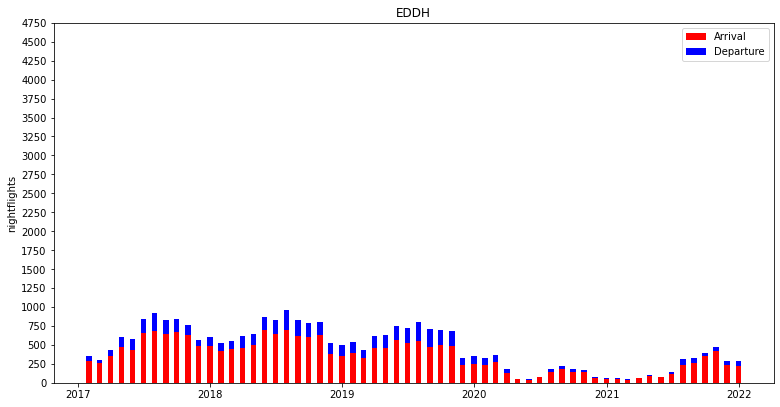

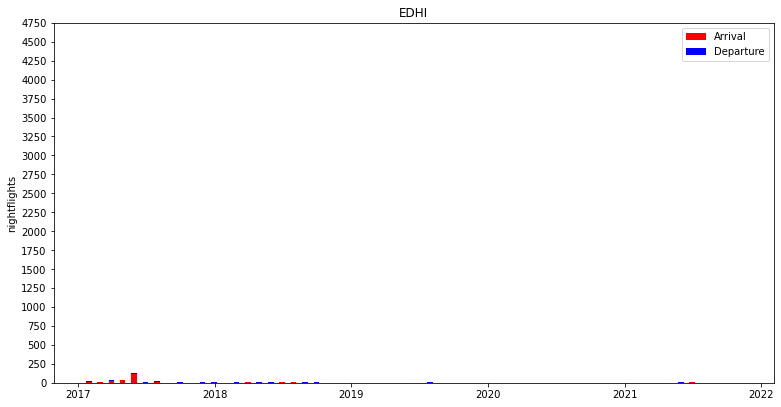

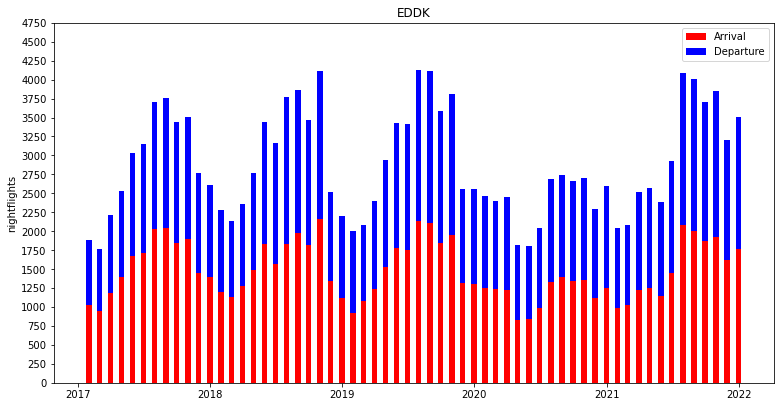

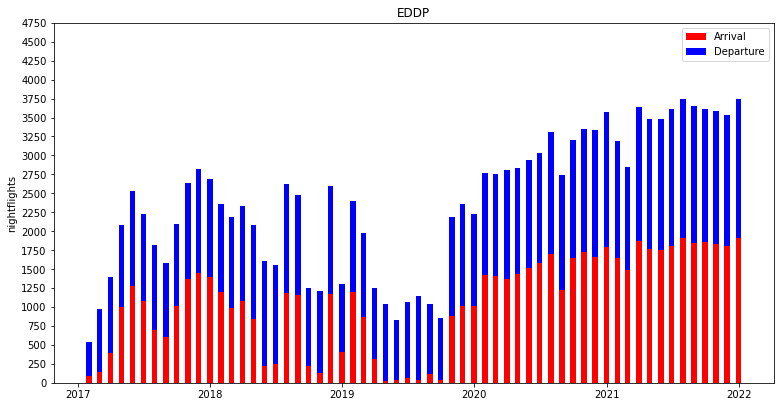

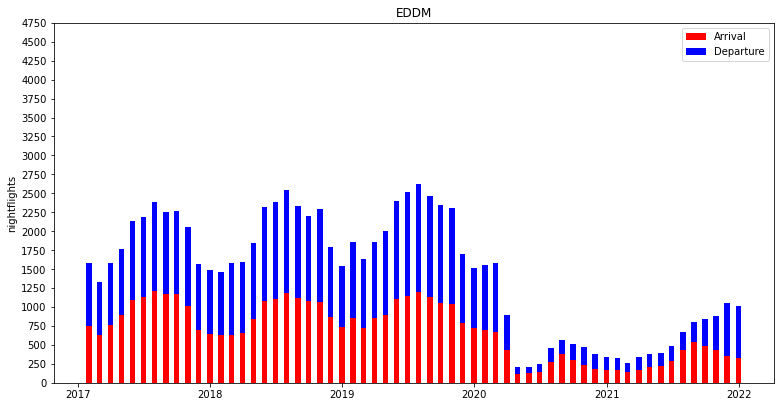

In [258]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airports = ['EDDB',
            'EDDW',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

fig, axs = plt.subplots(13)
fig.suptitle('Nightflights by arrival and departure')
for i, airport in enumerate(airports):
    arr_hh = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
    dep_hh = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
    ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
    width = 15
    fig = plt.figure(figsize=(10, 5))
    axs[i] = fig.add_axes([0,0,1,1])
    axs[i].bar(ind, arr_hh, width, color='r')
    axs[i].bar(ind, dep_hh, width, bottom=arr_hh, color='b')
    axs[i].set_title(airport)
    axs[i].set_ylabel('nightflights')
    axs[i].set_yticks(np.arange(0, 5000, 250))
    axs[i].legend(labels=['Arrival', 'Departure'])
    

    

## Finally it works without subplotting and by leaving out the january for Dortmund and the December from Berlin Tegel
## We can see that some airports have many nightflights and some have almost no nightflights

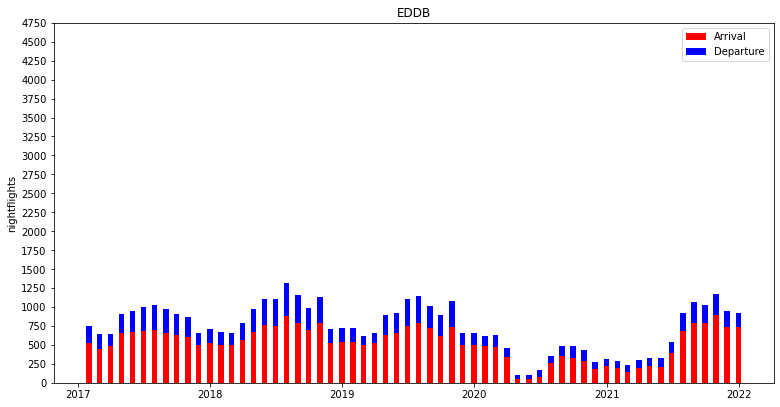

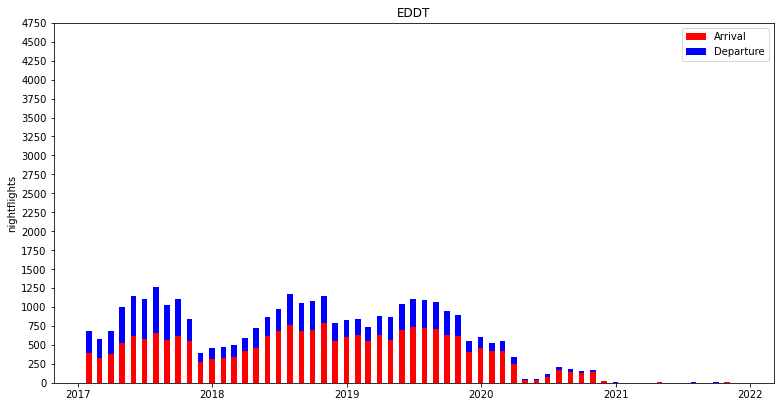

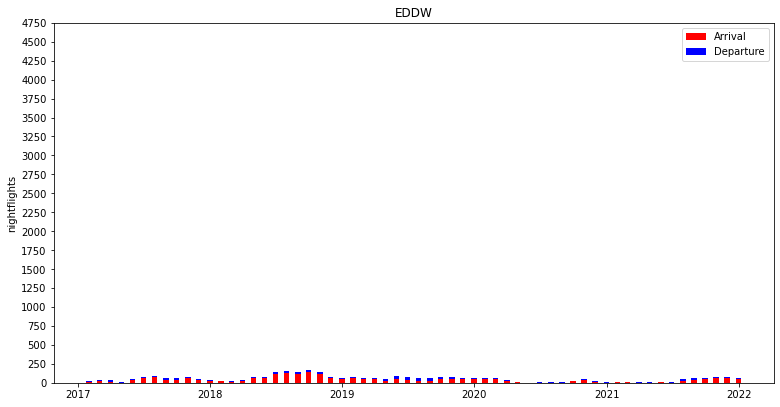

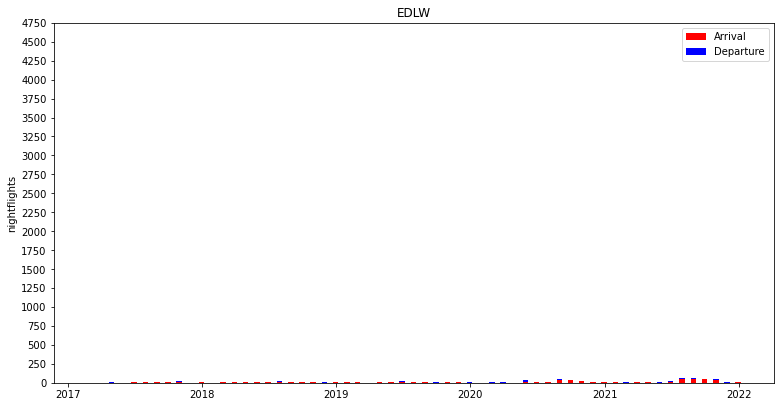

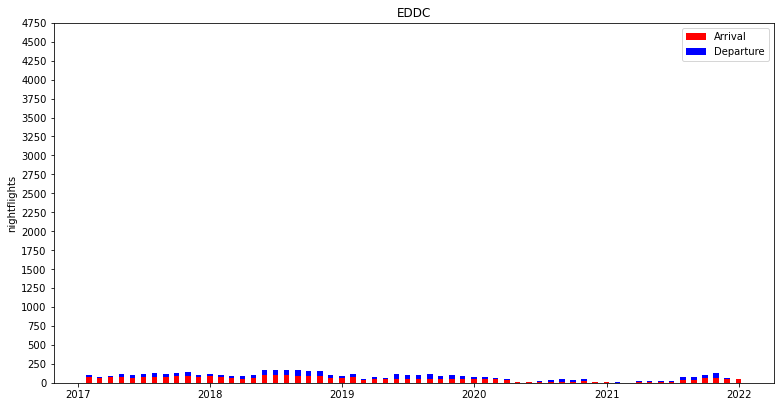

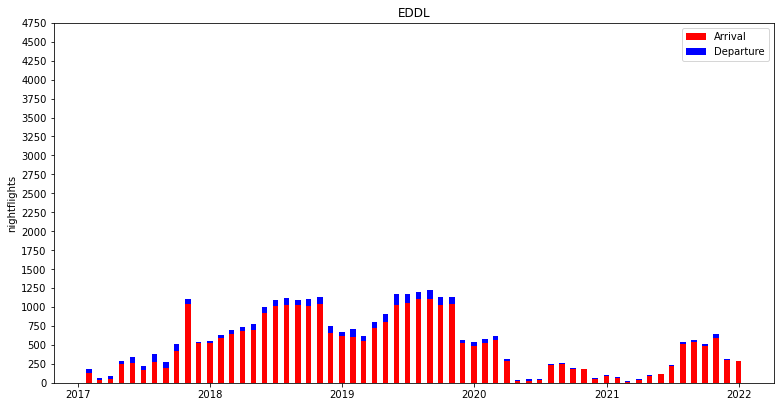

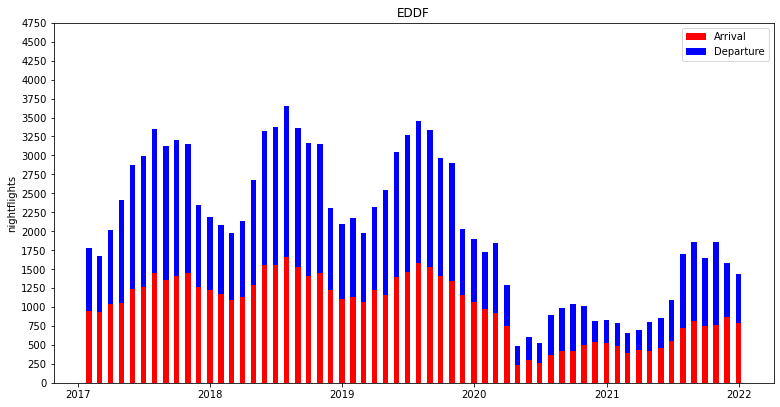

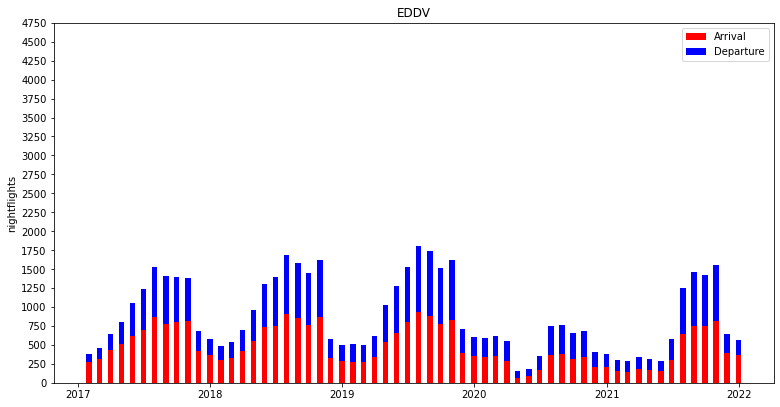

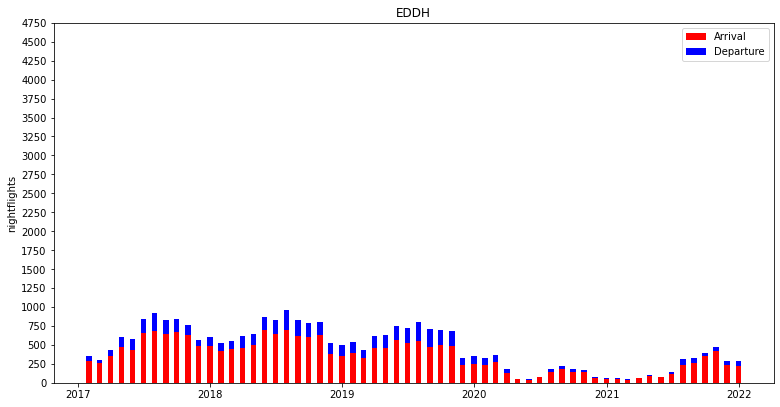

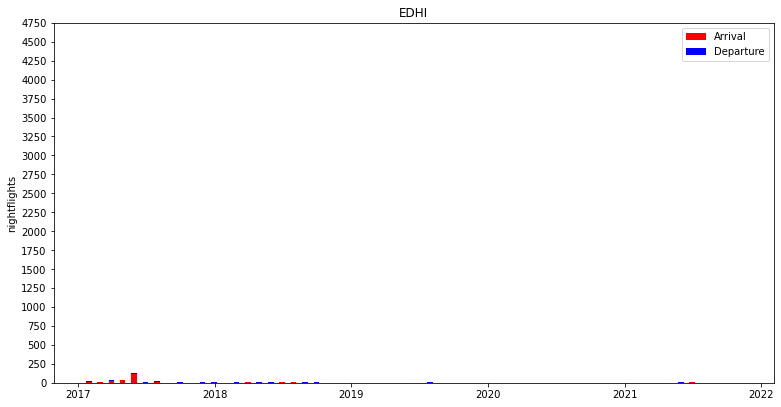

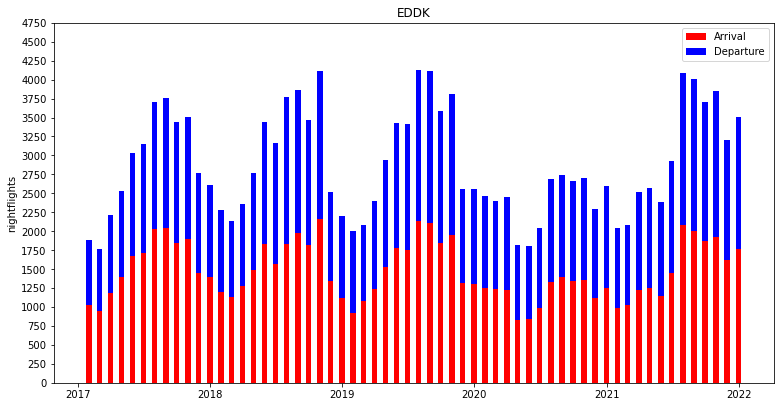

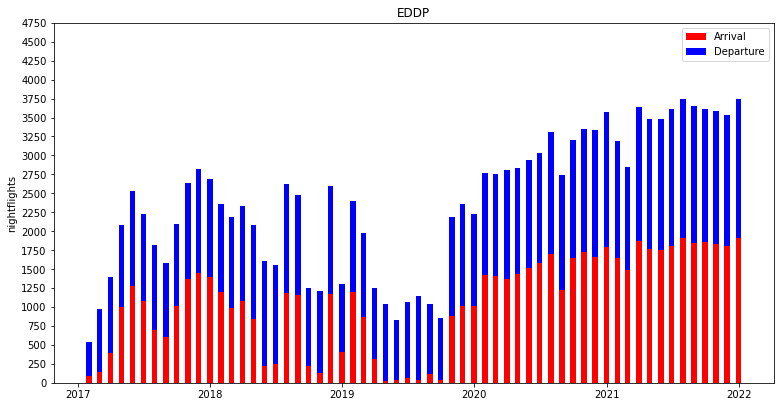

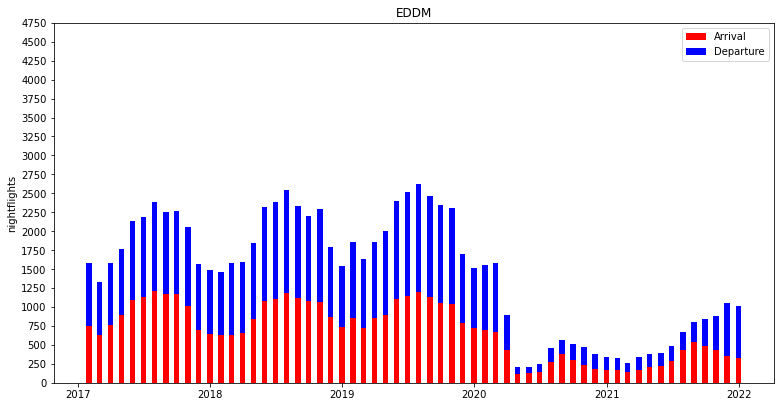

In [270]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airports = ['EDDB',
            'EDDT',
            'EDDW',
            'EDLW',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

for i, airport in enumerate(airports):
    if airport == 'EDDT':
        arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
        dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
        ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
        width = 15
        fig = plt.figure(figsize=(10, 5))
        axs[i] = fig.add_axes([0,0,1,1])
        axs[i].bar(ind, arr, width, color='r')
        axs[i].bar(ind, dep[:-1], width, bottom=arr, color='b')
        axs[i].set_title(airport)
        axs[i].set_ylabel('nightflights')
        axs[i].set_yticks(np.arange(0, 5000, 250))
        axs[i].legend(labels=['Arrival', 'Departure'])
    elif airport == 'EDLW':
        arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
        dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
        ind = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count().reset_index()['dep_date'] # the x locations for the groups
        width = 15
        fig = plt.figure(figsize=(10, 5))
        axs[i] = fig.add_axes([0,0,1,1])
        axs[i].bar(ind, arr[1:], width, color='r')
        axs[i].bar(ind, dep, width, bottom=arr[1:], color='b')
        axs[i].set_title(airport)
        axs[i].set_ylabel('nightflights')
        axs[i].set_yticks(np.arange(0, 5000, 250))
        axs[i].legend(labels=['Arrival', 'Departure'])
    else:
        arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
        dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
        ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
        width = 15
        fig = plt.figure(figsize=(10, 5))
        axs[i] = fig.add_axes([0,0,1,1])
        axs[i].bar(ind, arr, width, color='r')
        axs[i].bar(ind, dep, width, bottom=arr, color='b')
        axs[i].set_title(airport)
        axs[i].set_ylabel('nightflights')
        axs[i].set_yticks(np.arange(0, 5000, 250))
        axs[i].legend(labels=['Arrival', 'Departure'])
    

    

## Same over years

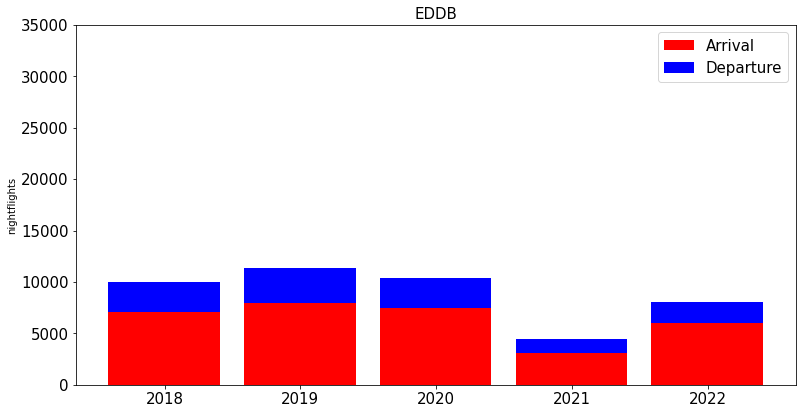

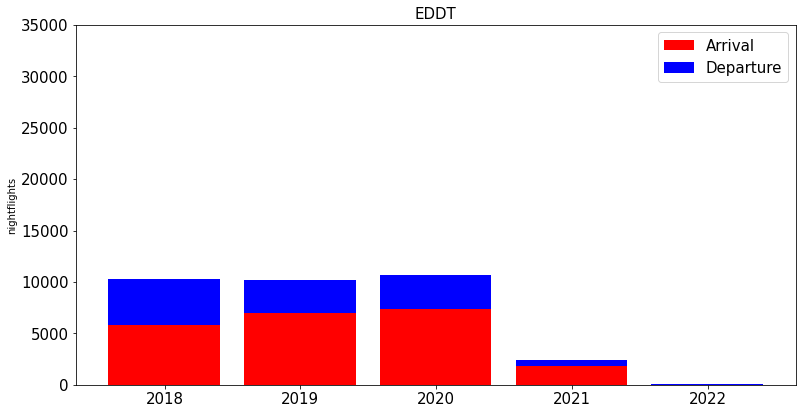

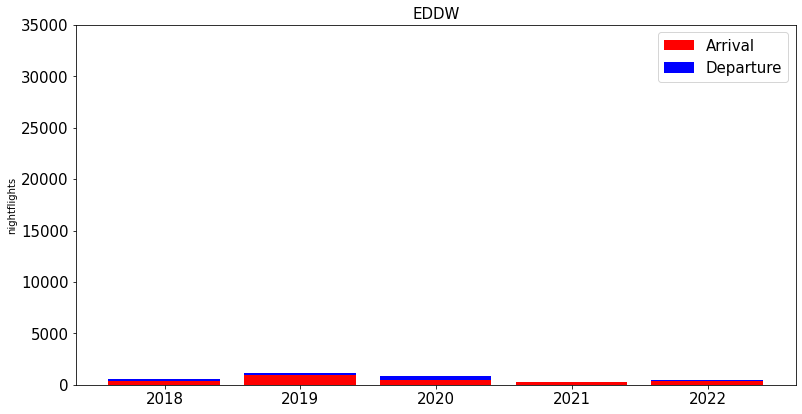

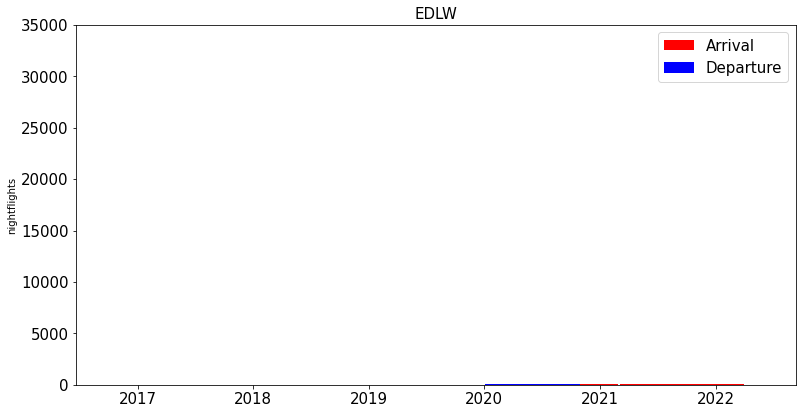

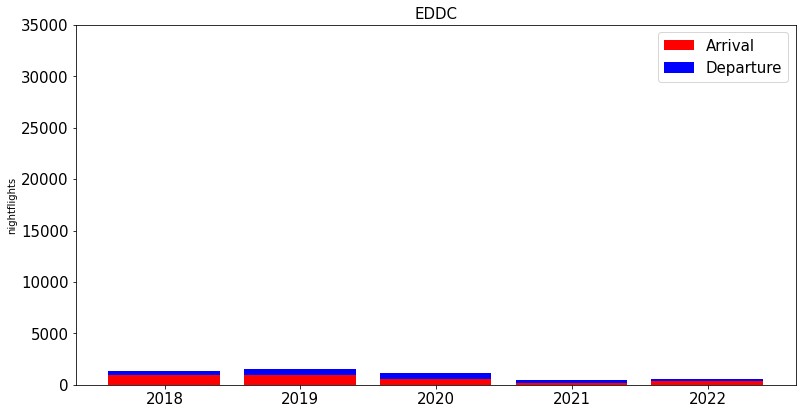

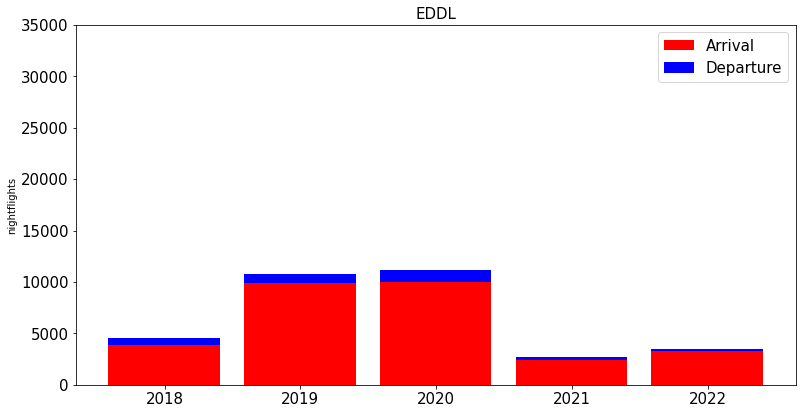

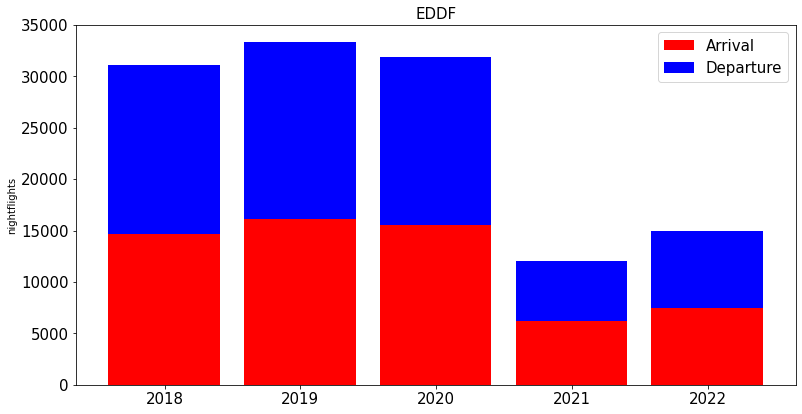

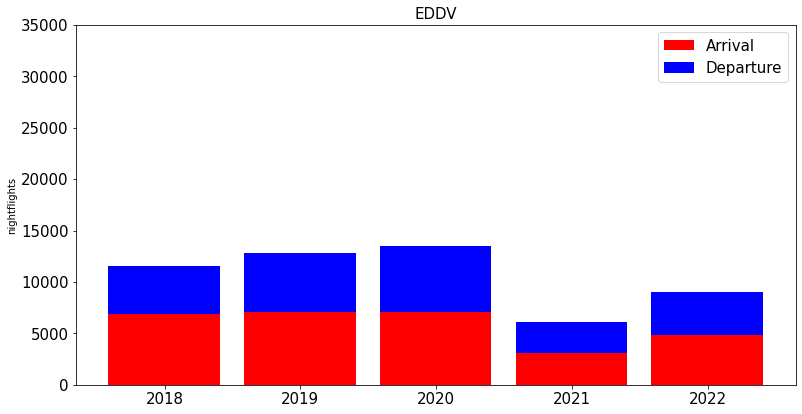

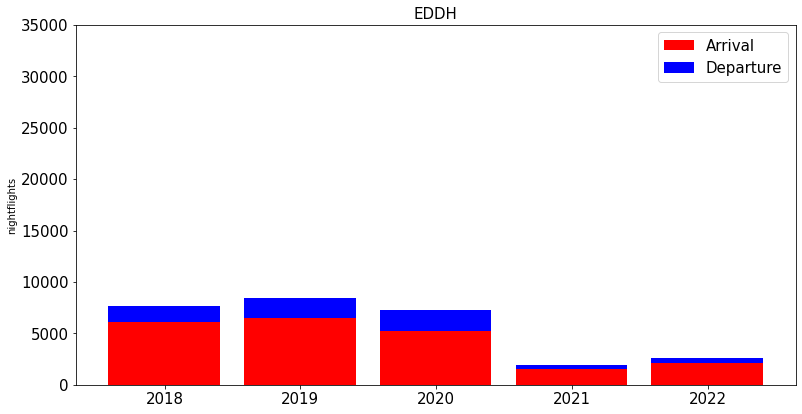

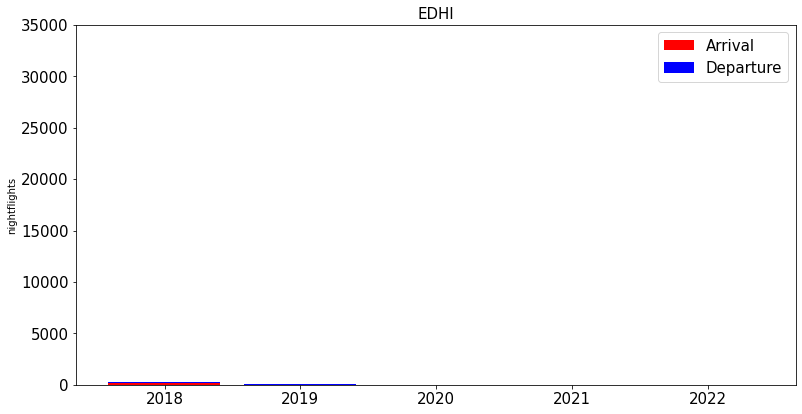

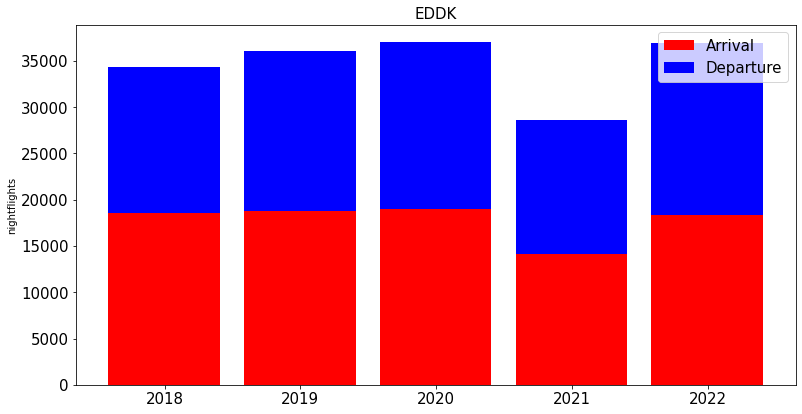

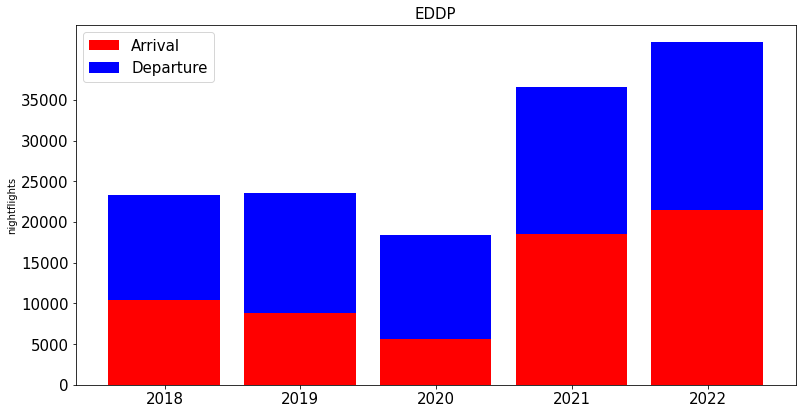

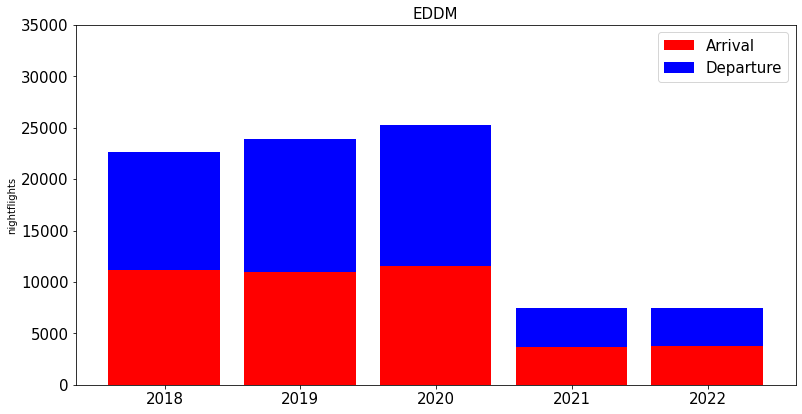

In [271]:
nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

airports = ['EDDB',
            'EDDT',
            'EDDW',
            'EDLW',
            'EDDC',
            'EDDL',
            'EDDF',
            'EDDV',
            'EDDH',
            'EDHI',
            'EDDK',
            'EDDP',
            'EDDM'  
            ]

nf['arr_date'] = pd.to_datetime(nf['arr_date'])
nf['dep_date'] = pd.to_datetime(nf['dep_date'])

for i, airport in enumerate(airports):
    if airport == 'EDLW':
        arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='M'))['arrival'].count()
        dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count()
        ind = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='M'))['departure'].count().reset_index()['dep_date'] # the x locations for the groups
        width = 300
        fig = plt.figure(figsize=(10, 5))
        axs[i] = fig.add_axes([0,0,1,1])
        axs[i].bar(ind, arr[1:], width, color='r')
        axs[i].bar(ind, dep, width, bottom=arr[1:], color='b')
        axs[i].set_title(airport, fontsize='15')
        axs[i].set_ylabel('nightflights')
        axs[i].set_yticks(np.arange(0, 40000, 5000))
        plt.xticks(fontsize='15')
        plt.yticks(fontsize='15')
        axs[i].legend(labels=['Arrival', 'Departure'], fontsize='15')
    else:
        arr = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count()
        dep = nf[nf['departure'] == airport].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
        ind = nf[nf['arrival'] == airport].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count().reset_index()['arr_date'] # the x locations for the groups
        width = 300
        fig = plt.figure(figsize=(10, 5))
        axs[i] = fig.add_axes([0,0,1,1])
        axs[i].bar(ind, arr, width, color='r')
        axs[i].bar(ind, dep, width, bottom=arr, color='b')
        axs[i].set_title(airport, fontsize='15')
        axs[i].set_ylabel('nightflights')
        axs[i].set_yticks(np.arange(0, 40000, 5000))
        plt.xticks(fontsize='15')
        plt.yticks(fontsize='15')
        axs[i].legend(labels=['Arrival', 'Departure'], fontsize='15')

## Leipzig and Köln/Bonn have clearly the most nightflights. 
## Köln/Bonn has no restrictions either
## Maybe because of cargo flights or also tourists?

## Can we see this also in the noise level data?

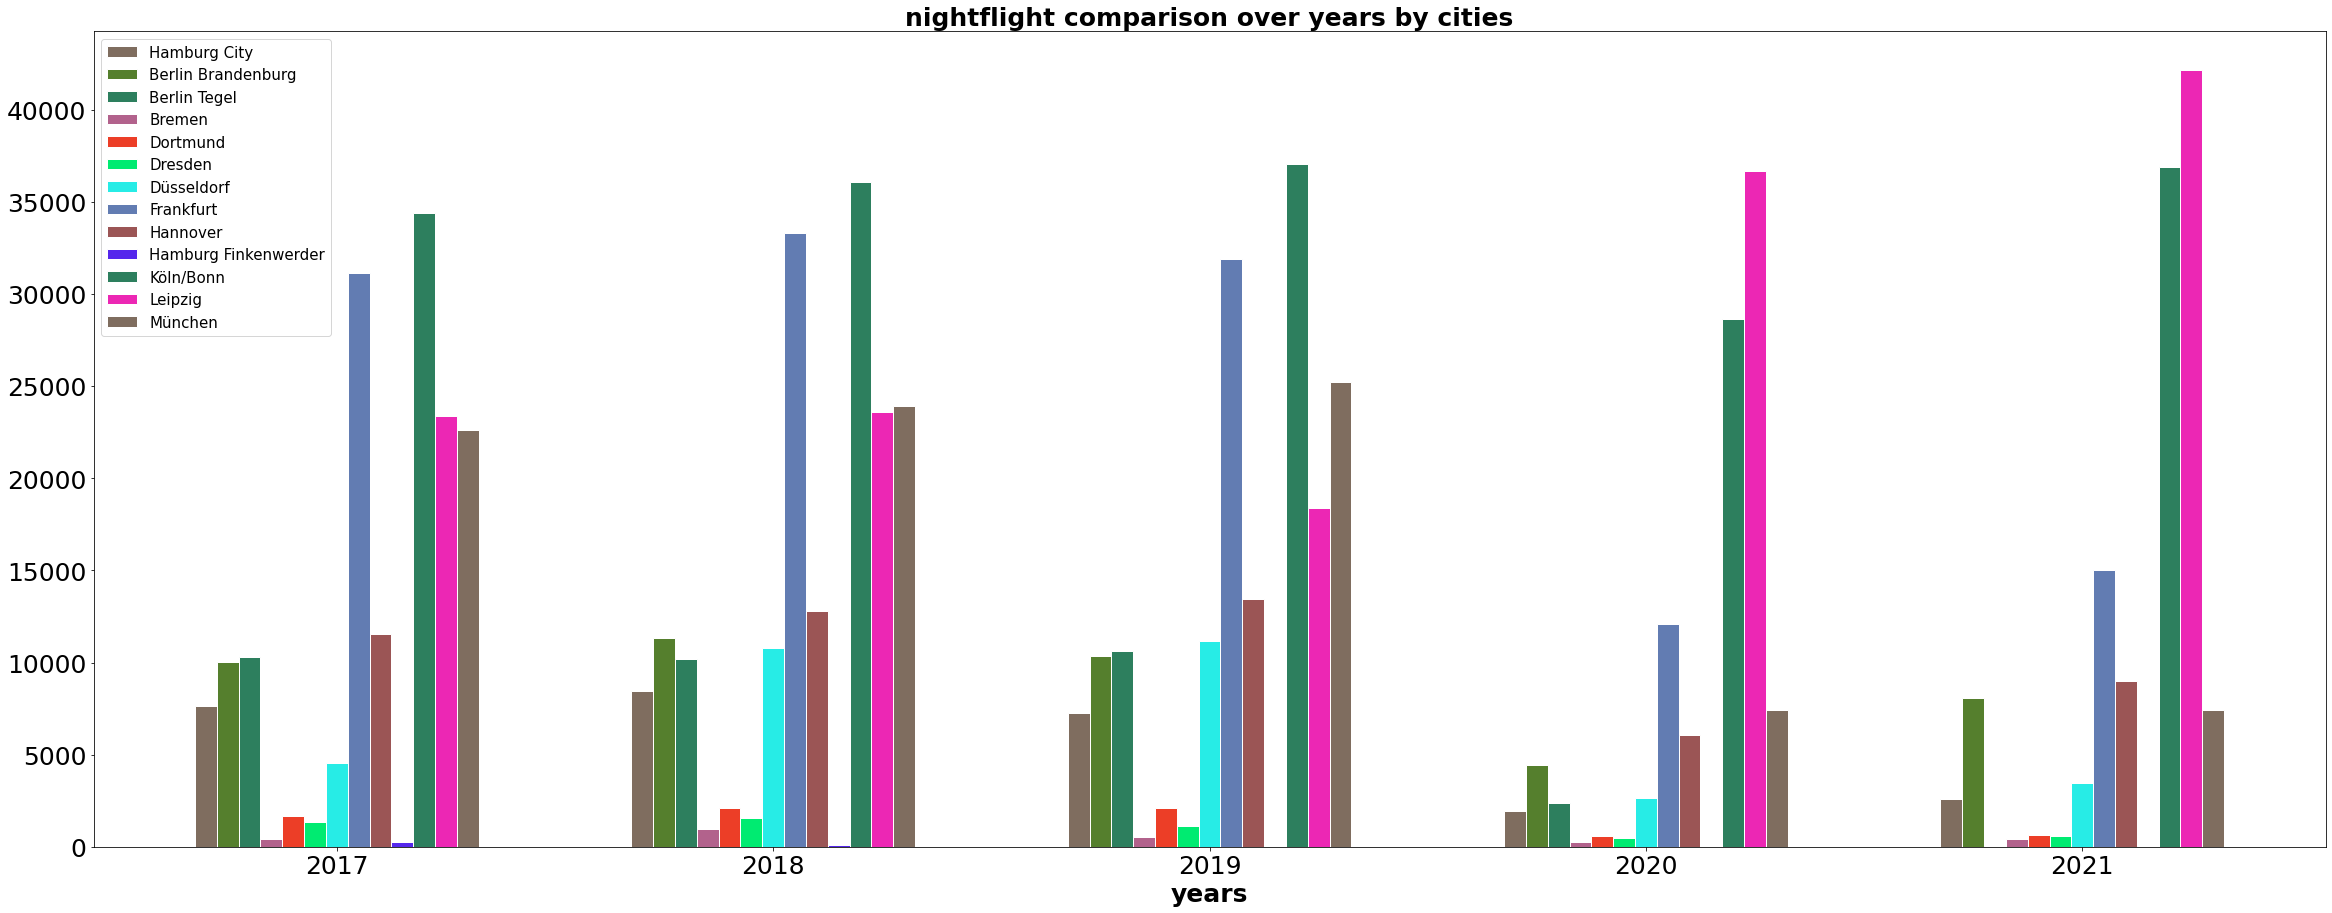

In [272]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bars
barWidth = 0.05

ger_airports = ['EDDB', # Berlin Brandenburg
                'EDDT', # Berlin Tegel
                'EDDW', # Bremen
                'EDLW', # Dortmund
                'EDDC', # Dresden
                'EDDL', # Duesseldorf
                'EDDF', # Frankfurt
                'EDDV', # Hannover 
                'EDDH', # Hamburg City
                'EDHI', # Hamburg Finkenwerder
                'EDDK', # Koeln/Bonn
                'EDDP', # Leipzig
                'EDDM'  # Muenchen
                ]
plt.figure(figsize=(40,15))
 
# set heights of bars
hh = nf[nf['arrival'] == 'EDDH'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDH'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
bb = nf[nf['arrival'] == 'EDDB'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDB'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
bt = nf[nf['arrival'] == 'EDDT'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDT'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
br = nf[nf['arrival'] == 'EDDW'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDLW'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
do = nf[nf['arrival'] == 'EDLW'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDH'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
dr = nf[nf['arrival'] == 'EDDC'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDC'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
du = nf[nf['arrival'] == 'EDDL'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDL'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
fr = nf[nf['arrival'] == 'EDDF'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDF'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
ha = nf[nf['arrival'] == 'EDDV'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDV'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
hf = nf[nf['arrival'] == 'EDHI'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDHI'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
kb = nf[nf['arrival'] == 'EDDK'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDK'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
le = nf[nf['arrival'] == 'EDDP'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDP'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()
mu = nf[nf['arrival'] == 'EDDM'].groupby(pd.Grouper(key='arr_date', freq='Y'))['arrival'].count() + nf[nf['departure'] == 'EDDM'].groupby(pd.Grouper(key='dep_date', freq='Y'))['departure'].count()

 
# Set position of bar on X axis
r1 = np.arange(len(hh))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
r12 = [x + barWidth for x in r11]
r13 = [x + barWidth for x in r12]
 
# Make the plot
plt.bar(r1, hh, color='#7f6d5f', width = barWidth, edgecolor='white', label='Hamburg City')
plt.bar(r2, bb, color='#557f2d', width = barWidth, edgecolor='white', label='Berlin Brandenburg')
plt.bar(r3, bt, color='#2d7f5e', width = barWidth, edgecolor='white', label='Berlin Tegel')
plt.bar(r4, br, color='#b2628c', width = barWidth, edgecolor='white', label='Bremen')
plt.bar(r5, do, color='#ec3e27', width = barWidth, edgecolor='white', label='Dortmund')
plt.bar(r6, dr, color='#00eb71', width = barWidth, edgecolor='white', label='Dresden')
plt.bar(r7, du, color='#27ece6', width = barWidth, edgecolor='white', label='Düsseldorf')
plt.bar(r8, fr, color='#627cb2', width = barWidth, edgecolor='white', label='Frankfurt')
plt.bar(r9, ha, color='#9b5555', width = barWidth, edgecolor='white', label='Hannover')
plt.bar(r10, hf, color='#5527ec', width = barWidth, edgecolor='white', label='Hamburg Finkenwerder')
plt.bar(r11, kb, color='#2d7f5e', width = barWidth, edgecolor='white', label='Köln/Bonn')
plt.bar(r12, le, color='#ec27b4', width = barWidth, edgecolor='white', label='Leipzig')
plt.bar(r13, mu, color='#7f6d5f', width = barWidth, edgecolor='white', label='München')
 
# Add xticks on the middle of the group bars
plt.title('nightflight comparison over years by cities', fontsize='25', fontweight='bold')
plt.xlabel('years', fontweight='bold', fontsize='25')
plt.yticks(fontsize='25')
plt.xticks([r + barWidth + 0.25 for r in range(len(hh))], ['2017', '2018', '2019', '2020', '2021'], fontsize='25')
 
# Create legend & Show graphic
plt.legend(fontsize='15')
plt.show()

## It looks like Hamburg Finkenwerder has no values. Maybe there are no nightflights in the city

 ## Ok. There are actually nightflights in Hamburg Finkenwerder but the difference to the leader Leipzig is so big that you can barely see the values in the chart
 ## Finkenwerder is not relevant so it's probably a good idea to exclude it
 ## Leipzig became first in nightflights in 2020
 ## The rest will be done in SQL and Tableau